<a href="https://colab.research.google.com/github/aframuneer26/Deep_Learning_Experiments/blob/main/DL_exp_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Using device: cpu
Epoch 1/10, Loss: 1.4150
Epoch 2/10, Loss: 1.0804
Epoch 3/10, Loss: 0.9309
Epoch 4/10, Loss: 0.8305
Epoch 5/10, Loss: 0.7496
Epoch 6/10, Loss: 0.6788
Epoch 7/10, Loss: 0.6132
Epoch 8/10, Loss: 0.5494
Epoch 9/10, Loss: 0.4875
Epoch 10/10, Loss: 0.4341
Accuracy on test data: 69.31%


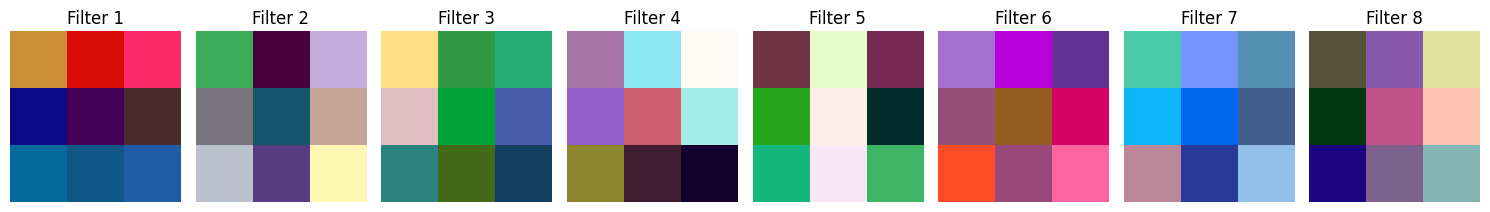

In [ ]:
# Step 1: Load and Preprocess CIFAR-10 Dataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Transformations: Convert to tensor and normalize for 3-channel images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Training dataset & loader
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Test dataset & loader
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Class names
classes = trainset.classes
print("Classes:", classes)

# Step 2: Define CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # Output: 16x32x32
        self.pool = nn.MaxPool2d(2, 2)                # After pool: 16x16x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Output: 32x16x16 → 32x8x8
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)   # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Train the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN().to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

# Step 4: Evaluate Model Performance
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

# Step 5: Visualize Learned Filters
def visualize_filters(layer, n_filters=8):
    filters = layer.weight.data.clone().cpu()
    fig, axs = plt.subplots(1, n_filters, figsize=(15, 4))
    for i in range(n_filters):
        f = filters[i]
        f = (f - f.min()) / (f.max() - f.min())  # Normalize for display
        axs[i].imshow(f.permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i+1}')
    plt.tight_layout()
    plt.show()

visualize_filters(model.conv1)
